# Выпускной проект: удержание клиентов путем оптимизации тарифных планов

Задача:

Телеком-провайдер «Нупозвони» ищет аналитиков! Мы хотим помочь колл-центрам найти неэффективных операторов, а также предложить им самые выгодные тарифы. 

План:
1. Загрузить данные:
   - Открыть csv фаилы с данными и сохранить их в двух датафреймах
   - Вывести первые строки каждого набора данных. Изучить общую информацию о датафрейме.
2. Провести предобработку данных:
   - Проверить наличие дупликатов
   - Проверить данные на пропуски
   - Обработать пропуски при необходимости:
     - Объяснить, почему заполнили пропуски определённым образом или почему не стали этого делать;
     - Описать причины, которые могли привести к пропускам;
   - Объеденим обе таблицы по столбцу user_id
   - Изменить типы данных некоторых столбцов
   - Проверить есть ли в датасете даты обслуживания клиентов, которые старше дат заключения с ними договоров
   - Добавить столбец с месячной абонентской платой
   - Написать промежуточный вывод
3. Провести исследовательский анализ данных:
   - Вычислить границы анализируемого периода
   - Построим график распределения количества звонков по датам
   - Проанализировать соотношение входящих и исходящих звонков
   - Посчитать количество пропущенных звонков   
   - Проанализировать общее количество звонков
   - Проанализировать общую длительность звонков
   - Проанализировать количество исходящих звонков по месяцам
   - Проанализировать общую продолжительность исходящих звонков по месяцам
   - Построить графики распределения абонентов по тарифным планам
   - Разделить клиентов на активных и неактивных
   - Построить график распределение активных клиентов по тарифным планам помесячно
4. Сделать следующие расчеты:
   - Посчитать количество операторов для каждого клиента помесячно
   - Посчитать расходы на исходящие звонки внутри сети
   - Посчитать суммарные расходы клиентов на исходящие звонки вне сети
   - Посчитать суммарные расходы по каждому тарифу в разрезе пользователей помесячно
   - Посчитать общую возможную экономию для клиентов за 4 месяца
   - Посчитать среднемесячную потенциальную экономию для клиентов
   - Подготовить список: идентификатор клиента; старый тарифный план; новый тарифный план
   - Построить графики с распределением пользователей по текущим тарифам и оптимальным
5. Проверим гипотезы
   - Стоимость услуг на тарифных планах A и B одинаковая
   - Время ожидания ответа на тарифных планах B и C одинаковое
6. Написать общий вывод

## 1 Загрузка данных

In [4]:
# Добавим необходимые библиотеки
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Настройки отображения
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [5]:
# Загружаем данные
dataset = pd.read_csv('/music/Practicum_projects/telecom_provider/datasets/telecom_dataset.csv')
clients = pd.read_csv('/music/Practicum_projects/telecom_provider/datasets/telecom_clients.csv')

In [6]:
# Выведем первые три строки
dataset.head(3)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1


In [7]:
# Изучим общую информацию первого датасета
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


In [8]:
# Выведем первые три строки второго датасета
clients.head(3)

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29


In [9]:
# Изучим общую информацию второго датасета
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


Мы загрузили данные из фаилов. В первом датасете есть пропуски. Названия столбцов редактировать не нужно. В некоторых столбцах нужно преобразовать данные в нужный тип.

## 2 Предобработка данных

### Проверим наличие дупликатов

In [13]:
# Проверим наличие явных дупликатов
dataset.duplicated().sum()

4900

Имеется 4,900(9%) явных дупликатов. Удалим их.

In [15]:
# Удаляем явные дупликаты
dataset = dataset.drop_duplicates().reset_index().drop('index', axis = 1)

In [16]:
# Проверим наличие явных дупликатов во втором датасете
clients.duplicated().sum()

0

### Проверим наличие пропусков

In [18]:
# Считаем пропуски
dataset.isna().sum()

user_id                   0
date                      0
direction                 0
internal                110
operator_id            7456
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

In [19]:
# Изучим также доли пропущенных значений
pd.DataFrame(round(dataset.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
user_id,0.000000
date,0.000000
direction,0.000000
internal,0.200000
operator_id,15.200000
is_missed_call,0.000000
calls_count,0.000000
call_duration,0.000000
total_call_duration,0.000000


- Удалим строки с пропущенными данными в столбце internal(их очень мало)
- В столбце operator_id пропусков много(15.2%). Их удалять нельзя, так как это может искозить результаты исследования (либо значительная часть клиентов уйдет от нас, которая нам приносит прибыль). Пропуски могут быть связаны с какими-то техническими проблемами(система не указывает оператора из-за технического сбоя). Заменим эти пропуски самыми часто встречаемыми операторами у данных клиентов(user_id)

In [21]:
# Удалим строки с пропущенными данными с столбце 'internal'
dataset = dataset.dropna(subset=['internal'])

In [22]:
# Выведем первые три строки
dataset.head(3)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1


In [23]:
# Шаг 1: Фильтрация по строке, где оператор отсутствует (NaN)
filtered_dataset = dataset[pd.isna(dataset['operator_id'])]

# Шаг 2: Группировка по признаку is_missed_call и подсчет числа строк
result = filtered_dataset.groupby('is_missed_call').size()

result

is_missed_call
False     113
True     7288
dtype: int64

Большинство звонков с пропущенным значением в поле operator_id это пропущенные звонки. Вероятно система не успевает назначить оператора. Заполним пропущенные значения в столбце operator_id на самые часто встречаемые значения у пользователя.

In [25]:
# Выведем первые три строки
dataset.head(3)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1


In [26]:
# Фильтруем возможные пропуски и считаем глобальную моду
#global_mode = dataset['operator_id'].dropna().mode()[0]
GLOBAL_MODE_CONSTANT = 111111

# Обработчик пропуска и нахождения моды
def fill_with_mode(group):
    try:
        # Попытка вычисления моды
        mode_value = group.mode()[0]
    except Exception:
        # Если нельзя найти моду, возвращаем глобальную моду
        mode_value = GLOBAL_MODE_CONSTANT
        
    return group.fillna(mode_value)

# Преобразование с учётом нового обработчика
dataset['operator_id'] = dataset.groupby('user_id')['operator_id'].transform(fill_with_mode)

In [27]:
# Проверим результат
pd.DataFrame(round(dataset.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
user_id,0.000000
date,0.000000
direction,0.000000
internal,0.000000
operator_id,0.000000
is_missed_call,0.000000
calls_count,0.000000
call_duration,0.000000
total_call_duration,0.000000


In [28]:
# Проверим еще раз общую информацию по датасету
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48892 entries, 0 to 49001
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              48892 non-null  int64  
 1   date                 48892 non-null  object 
 2   direction            48892 non-null  object 
 3   internal             48892 non-null  object 
 4   operator_id          48892 non-null  float64
 5   is_missed_call       48892 non-null  bool   
 6   calls_count          48892 non-null  int64  
 7   call_duration        48892 non-null  int64  
 8   total_call_duration  48892 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.4+ MB


### Объединим два датасета

Объединим два датасета

In [31]:
telecom = dataset.merge(clients, on = 'user_id')

In [32]:
# Выведем первые три строки
telecom.head(3)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start
0,166377,2019-08-04 00:00:00+03:00,in,False,880028.0,True,2,0,4,B,2019-08-01
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5,B,2019-08-01
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1,B,2019-08-01


In [33]:
# Посмотрим общую информацию по объединенному датасету
telecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48892 entries, 0 to 48891
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              48892 non-null  int64  
 1   date                 48892 non-null  object 
 2   direction            48892 non-null  object 
 3   internal             48892 non-null  object 
 4   operator_id          48892 non-null  float64
 5   is_missed_call       48892 non-null  bool   
 6   calls_count          48892 non-null  int64  
 7   call_duration        48892 non-null  int64  
 8   total_call_duration  48892 non-null  int64  
 9   tariff_plan          48892 non-null  object 
 10  date_start           48892 non-null  object 
dtypes: bool(1), float64(1), int64(4), object(5)
memory usage: 3.8+ MB


В объединенный датасет вошли все строки из основного датасета dataset

In [35]:
# Проверим есть ли у каждого пользователя тарифный план
missing_tariffs = telecom.loc[pd.isna(telecom['tariff_plan']), 'user_id']

missing_tariffs

Series([], Name: user_id, dtype: int64)

У всех клиентов указан тарифный план(нет пропусков).

In [37]:
# Проверка количества уникальных тарифов для каждого пользователя
unique_counts = telecom.groupby('user_id')['tariff_plan'].nunique()
unique_counts.head(3)

user_id
166377    1
166391    1
166392    1
Name: tariff_plan, dtype: int64

In [38]:
# Фильтруем тех пользователей, у кого больше одного тарифа
users_with_multiple_plans = unique_counts[unique_counts > 1]

if len(users_with_multiple_plans) > 0:
    print(f"Пользователи с несколькими тарифами:\n{users_with_multiple_plans}")
else:
    print("У каждого пользователя только один тариф.")

У каждого пользователя только один тариф.


У каждого пользователя только один тариф.

### Изменим типы данных некоторых столбцов

In [41]:
# Преобразуем колонку 'date' в формат даты без времени
telecom['date'] = pd.to_datetime(telecom['date']).dt.tz_localize(None)

# Преобразуем колонку 'date_start' в формат даты без времени
telecom['date_start'] = pd.to_datetime(telecom['date_start'])

# Приведение идентификаторов операторов к целочисленному типу int
telecom['operator_id'] = telecom['operator_id'].astype('int')

# Приведем тип данныйх к булевому в столбце internal
telecom['internal'] = telecom['internal'].astype(bool)

In [42]:
telecom.head(3)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start
0,166377,2019-08-04,in,False,880028,True,2,0,4,B,2019-08-01
1,166377,2019-08-05,out,True,880022,True,3,0,5,B,2019-08-01
2,166377,2019-08-05,out,True,880020,True,1,0,1,B,2019-08-01


In [43]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48892 entries, 0 to 48891
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              48892 non-null  int64         
 1   date                 48892 non-null  datetime64[ns]
 2   direction            48892 non-null  object        
 3   internal             48892 non-null  bool          
 4   operator_id          48892 non-null  int32         
 5   is_missed_call       48892 non-null  bool          
 6   calls_count          48892 non-null  int64         
 7   call_duration        48892 non-null  int64         
 8   total_call_duration  48892 non-null  int64         
 9   tariff_plan          48892 non-null  object        
 10  date_start           48892 non-null  datetime64[ns]
dtypes: bool(2), datetime64[ns](2), int32(1), int64(4), object(2)
memory usage: 3.3+ MB


### Проверим есть ли в датасете даты обслуживания клиентов, которые старше дат заключения с ним договоров

In [45]:
print('Количество записей обсуживания клиентов с датами старше дат их регистрации:', 
      len(telecom[telecom['date'] < telecom['date_start'] ]))

Количество записей обсуживания клиентов с датами старше дат их регистрации: 0


### Добавим столбец с месячной абонентской платой

In [47]:
# Заданные фиксированные платежи по тарифам
MONTHLY_FEE_TARIFF_A = 5000  # Ежемесячная оплата по тарифу А
MONTHLY_FEE_TARIFF_B = 2000  # Ежемесячная оплата по тарифу Б
MONTHLY_FEE_TARIFF_C = 1000  # Ежемесячная оплата по тарифу С

# Определение функции для расчета ежемесячной оплаты
def calculate_current_monthly_fee(row):
    """
    Возвращает сумму ежемесячной платы в зависимости от текущего тарифного плана.
    """
    if row['tariff_plan'] == 'A':
        return MONTHLY_FEE_TARIFF_A
    elif row['tariff_plan'] == 'B':
        return MONTHLY_FEE_TARIFF_B
    elif row['tariff_plan'] == 'C':
        return MONTHLY_FEE_TARIFF_C
    else:
        return None  # Можно заменить другим значением по умолчанию

# Применение функции для формирования нового столбца 'cur_monthly_fee'
telecom['cur_monthly_fee'] = telecom.apply(calculate_current_monthly_fee, axis=1)

In [48]:
# Выведем первые три строки
telecom.head(3)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start,cur_monthly_fee
0,166377,2019-08-04,in,False,880028,True,2,0,4,B,2019-08-01,2000
1,166377,2019-08-05,out,True,880022,True,3,0,5,B,2019-08-01,2000
2,166377,2019-08-05,out,True,880020,True,1,0,1,B,2019-08-01,2000


Мы провели предобработку данных:
- Привели наличие дупликатов. Идентифицировали 4,900(9%) явных дубликата. Удалили их.
- Проверили наличие пропусков:
  - Удалили строки с пропущенными данными в столбце internal(их очень мало)
  - В столбце operator_id пропусков идентифицированно в размере 7,456 штук(15.2%). Их удалять не стали, так как это может искозить результаты исследования (как следствие значительная часть клиентов уйдет от нас, которая нам приносит прибыль). Пропуски могут быть связаны с какими-то техническими проблемами(система не указывает оператора из-за технического сбоя). Заменили эти пропуски самыми часто встречаемыми операторами у данных клиентов(user_id)
- Объединили два датасета по столбцу user_id и проверили:
  - В объединенный датасет вошли все строки из основного датасета dataset
  - У всех клиентов указан тарифный план(нет пропусков)
  - У каждого пользователя только один тариф
- Изменили типы данных некоторых столбцов:
  - Преобразовали столбец 'date' в формат даты без времени
  - Преобразовали столбец 'date_start' в формат даты без времени
  - Привели идентификаторов операторов к целочисленному типу int
  - Привели тип данныйх к булевому в столбце internal
- Проверили есть ли в датасете даты обслуживания клиентов, которые старше дат заключения с ними договоров. Количество записей обсуживания клиентов с датами старше дат их регистрации: 0.
- Добавили столбец с месячной абонентской платой cur_monthly_fee

## 3 Исследовательский анализ данных

### Вычислим границы анализуемого периода и добавим столбец с месяцем когда были оказаны услуги

In [52]:
# Посмотрим за какой период данные
print("Начало периода:", dataset["date"].min())
print("Конец периода:", dataset["date"].max())

Начало периода: 2019-08-02 00:00:00+03:00
Конец периода: 2019-11-28 00:00:00+03:00


In [53]:
# Добавим столбец 'month', содержащий месяцы
telecom['month'] = pd.to_datetime(telecom['date']).dt.month
print(telecom['month'].unique())

[ 8  9 10 11]


Итак, у нас данные за 4 месяца 2019 года: август, сентябрь, октябрь и ноябрь. У нас не хватает одного дня в августе(29 вместо 30) и двух дней в ноябре(28 вместо 30). Посчитаем среднее количесво дней и отклонение от среднего.

In [55]:
# Определяем полный диапазон дней в месяцах
months = ['Август', 'Сентябрь', 'Октябрь', 'Ноябрь']
days_in_months = {'Август': 30, 'Сентябрь': 30, 'Октябрь': 31, 'Ноябрь': 28}

# Подсчёт общего количества дней
total_days = sum(days_in_months.values())   # минус три дня (один в августе и два в ноябре)
num_months = len(months)

# Рассчитываем среднее количество дней
average_days_per_month = total_days / num_months
print(f"Среднее количество дней в месяцах: {average_days_per_month:.2f}")

august_days = days_in_months['Август']  # количество дней в августе
november_days = days_in_months['Ноябрь']  # количество дней в ноябре

# Расчет процентов отклонения
deviation_august_percent = abs(august_days - average_days_per_month) / average_days_per_month * 100
deviation_november_percent = abs(november_days - average_days_per_month) / average_days_per_month * 100

# Вывод результатов
print(f"Отклонение в августе: {deviation_august_percent:.2f}%")
print(f"Отклонение в ноябре: {deviation_november_percent:.2f}%")

Среднее количество дней в месяцах: 29.75
Отклонение в августе: 0.84%
Отклонение в ноябре: 5.88%


Отклонение в августе несущественное. В ноябре чуть больше. Учитывая что мы ниже выяснили, что самый большой трафик приходится на ноябрь, не стоит ноябрьские данные редактировать(урезать), так как мы можем потерять ценную информацию для принятия решения по переводу клиентов на новый тариф.

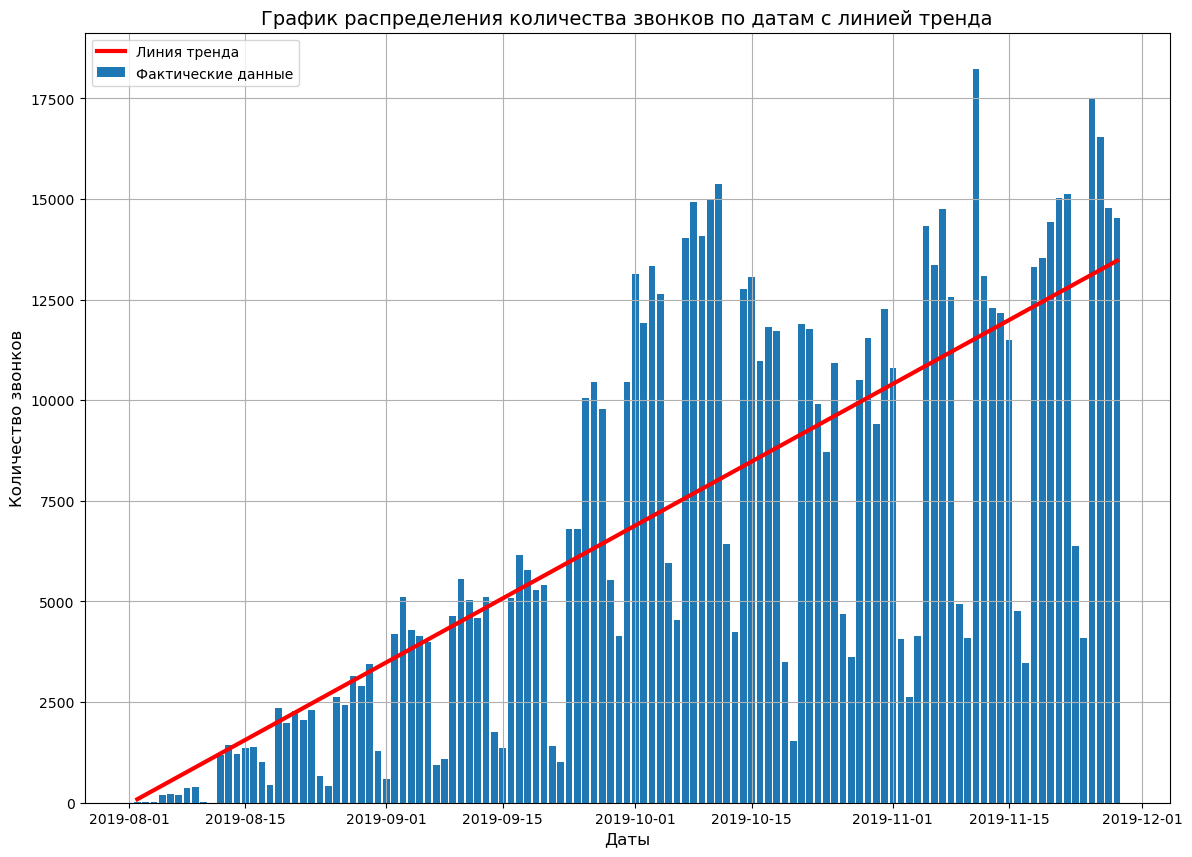

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Предположим, что ваша таблица выглядит примерно так:
telecom_calls_sum_by_date = telecom.pivot_table(index=['date'], values='calls_count', aggfunc='sum').reset_index()

# Конвертируем даты в целочисленные значения (нужны для расчета тренда)
dates_numeric = (pd.to_datetime(telecom_calls_sum_by_date['date']) - pd.to_datetime(telecom_calls_sum_by_date['date'][0])).dt.days.values

# Рассчитываем коэффициенты прямой (линейной модели)
coefficients = np.polyfit(dates_numeric, telecom_calls_sum_by_date['calls_count'], 1)
polynomial = np.poly1d(coefficients)

# Строим сами данные
plt.figure(figsize=(14, 10))
plt.bar(telecom_calls_sum_by_date['date'], telecom_calls_sum_by_date['calls_count'], label='Фактические данные')

# Линия тренда строится сверху графиков
line_trend = polynomial(dates_numeric)
plt.plot(telecom_calls_sum_by_date['date'], line_trend, color='red', linewidth=3, label='Линия тренда')

# Описание элементов графика
plt.xlabel('Даты', fontsize=12)
plt.ylabel('Количество звонков', fontsize=12)
plt.title('График распределения количества звонков по датам с линией тренда', fontsize=14)
plt.grid(True)
plt.legend()  # добавляем легенду
plt.show()

Количество звонков растет от месяца к месяцу. Бизнес развивается. Провалы - это выходные.

### Посмотрим соотношение входящих и исходящих звонков

In [60]:
telecom_in_out_calls = (
    telecom
    .groupby('direction')['direction']     # Группировка по типу и подсчет типов
    .count()                      # Считаем количество звонков в каждом типе
    .sort_values(ascending=False) # Сортируем по убыванию количества звонков
    .reset_index(name='count')    # Преобразуем индекс обратно в колонку
)

# Выводим итоговую таблицу
telecom_in_out_calls

,direction,count
0,out,28997
1,in,19895


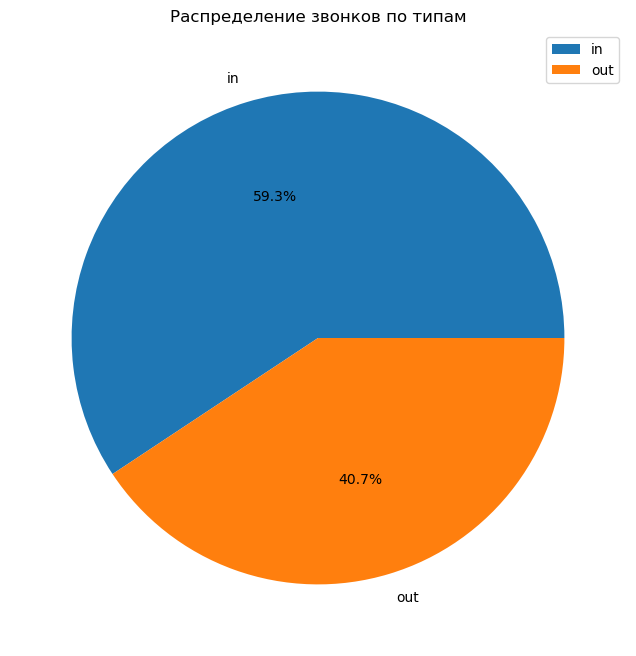

In [61]:
# Создание круговой диаграммы распределения игр по типам
telecom_in_out_calls.plot(
    kind='pie',            # Тип графика - круговая диаграмма
    y='count',              # Столбец для отображения долей
    autopct='%1.1f%%',     # Формат процентов с одним знаком после запятой
    labels=telecom['direction'],  # Метки для типов
    figsize=(12, 8),      # Размеры графика
    title='Распределение звонков по типам'    # Название графика
)

# Удаляем подпись оси Y
plt.ylabel('')

# Отображение графика
plt.show()

Распределение примерно одинаковое. При этом, входящих звонков больше. Они бесплатные. Но клиенты, которые используют только входящие звонки, платят ежемесячную абонентскую плату плюс за каждого оператора. Их удалаять нельзя.

### Посчитаем количество пропущенных звонков

In [64]:
telecom_is_missed_call = (
    telecom
    .groupby('is_missed_call')['is_missed_call']     # Группировка по типу звонка и подсчет количества
    .count()                      # Считаем количество звонков по каждому типу
    .sort_values(ascending=False) # Сортируем по убыванию количества
    .reset_index(name='count')    # Преобразуем индекс обратно в колонку
)

# Выводим итоговую таблицу
telecom_is_missed_call

,is_missed_call,count
0,False,27495
1,True,21397


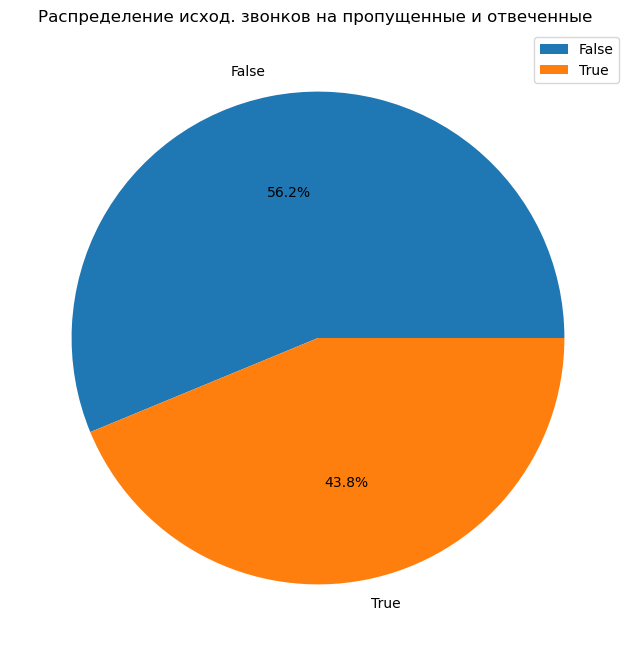

In [65]:
# Создание круговой диаграммы распределения звонков на пропущенные и отвеченные
telecom_is_missed_call.plot(
    kind='pie',            # Тип графика - круговая диаграмма
    y='count',              # Столбец для отображения долей
    autopct='%1.1f%%',     # Формат процентов с одним знаком после запятой
    labels=telecom_is_missed_call['is_missed_call'],  # Метки для секторов
    figsize=(12, 8),      # Размеры графика
    title='Распределение исход. звонков на пропущенные и отвеченные '    # Название графика
)

# Удаляем подпись оси Y
plt.ylabel('')

# Отображение графика
plt.show()

Довольно много пропущенных вызовов(43.8%). Они нам не нужны для дальнейших расчетов. Удалим их.

In [67]:
filtered_telecom_one = telecom.query('is_missed_call == False')

# Выводим общую информацию
filtered_telecom_one.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27495 entries, 3 to 48890
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              27495 non-null  int64         
 1   date                 27495 non-null  datetime64[ns]
 2   direction            27495 non-null  object        
 3   internal             27495 non-null  bool          
 4   operator_id          27495 non-null  int32         
 5   is_missed_call       27495 non-null  bool          
 6   calls_count          27495 non-null  int64         
 7   call_duration        27495 non-null  int64         
 8   total_call_duration  27495 non-null  int64         
 9   tariff_plan          27495 non-null  object        
 10  date_start           27495 non-null  datetime64[ns]
 11  cur_monthly_fee      27495 non-null  int64         
 12  month                27495 non-null  int32         
dtypes: bool(2), datetime64[ns](2), int32

### Проанализируем общее количество звонков среди клиентов

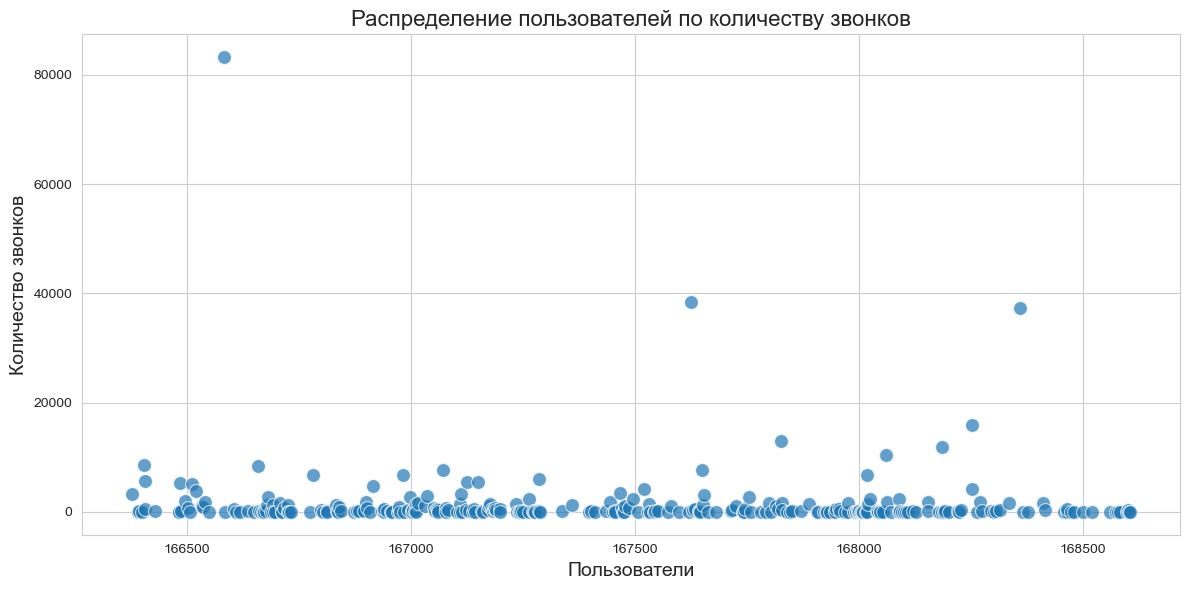

In [258]:
# Формирование свода данных
telecom_calls_sum = filtered_telecom_one.pivot_table(index=['user_id'], values='calls_count', aggfunc='sum').reset_index()

# Настройка стиля графика
sns.set_style("whitegrid")

# Создание графика
fig, ax = plt.subplots(figsize=(12, 6))  # Увеличенный размер окна

# Plot с использованием Seaborn
sns.scatterplot(x="user_id", y="calls_count", data=telecom_calls_sum, s=100, alpha=0.7)

# Заголовок и метки осей
ax.set_title('Распределение пользователей по количеству звонков', fontsize=16)
ax.set_xlabel('Пользователи', fontsize=14)
ax.set_ylabel('Количество звонков', fontsize=14)

# Сохранение фигуры
plt.tight_layout()
plt.show()

In [70]:
# Выведем общую информацию
telecom_calls_sum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   user_id      287 non-null    int64
 1   calls_count  287 non-null    int64
dtypes: int64(2)
memory usage: 4.6 KB


In [71]:
# Выведем основные статистические характеристики
round(telecom_calls_sum['calls_count'].describe(),1)

count      287.0
mean      1500.8
std       6106.7
min          1.0
25%         21.5
50%        140.0
75%        869.5
max      83276.0
Name: calls_count, dtype: float64

В 75% случаях на одного клиента приходится до 869 звонка. Имеется большое количество выбросов. Самое большое количество - 83,276 звонков. Для фильтрации определим границы: нижняя граница - 1-й процентиль(0.01), верхняя граница - 99-й процентиль(0.99). Такой подход оставляет ещё меньше экстремумов, оставляя лишь самые центрированные данные.

In [73]:
# Определение нижнего и верхнего квантилей (1% и 99%)
q_low = telecom_calls_sum['calls_count'].quantile(0.01)
q_high = telecom_calls_sum['calls_count'].quantile(0.99)

# Фильтрация данных: остаются только те, кто попадает в указанный диапазон
telecom_calls_sum_filtered = telecom_calls_sum[(telecom_calls_sum['calls_count'] >= q_low) & (telecom_calls_sum['calls_count'] <= q_high)]

# Вывод общей информации
telecom_calls_sum_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 284 entries, 0 to 286
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   user_id      284 non-null    int64
 1   calls_count  284 non-null    int64
dtypes: int64(2)
memory usage: 6.7 KB


In [74]:
# Выведем основные статистические характеристики
round(telecom_calls_sum_filtered['calls_count'].describe(),1)

count      284.0
mean       957.0
std       2104.6
min          1.0
25%         20.8
50%        138.0
75%        782.5
max      15852.0
Name: calls_count, dtype: float64

In [75]:
# Фильтрация telecom по списку операторов из telecom_calls_sum_filtered
filtered_telecom_two = filtered_telecom_one[
    filtered_telecom_one['user_id'].isin(telecom_calls_sum_filtered['user_id'])
]

# Просмотр первых нескольких строк нового фильтрационного набора
filtered_telecom_two.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26022 entries, 3 to 48890
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              26022 non-null  int64         
 1   date                 26022 non-null  datetime64[ns]
 2   direction            26022 non-null  object        
 3   internal             26022 non-null  bool          
 4   operator_id          26022 non-null  int32         
 5   is_missed_call       26022 non-null  bool          
 6   calls_count          26022 non-null  int64         
 7   call_duration        26022 non-null  int64         
 8   total_call_duration  26022 non-null  int64         
 9   tariff_plan          26022 non-null  object        
 10  date_start           26022 non-null  datetime64[ns]
 11  cur_monthly_fee      26022 non-null  int64         
 12  month                26022 non-null  int32         
dtypes: bool(2), datetime64[ns](2), int32

In [76]:
# Получаем количество строк в каждом датафрейме
rows_filtered_telecom_one = len(filtered_telecom_one)
rows_filtered_telecom_two = len(filtered_telecom_two)

# Определяем больший и меньший датафреймы
bigger_rows = max(rows_filtered_telecom_one, rows_filtered_telecom_two)
smaller_rows = min(rows_filtered_telecom_one, rows_filtered_telecom_two)

# Вычисляем процент
percentage_difference = (1-smaller_rows / bigger_rows) * 100

# Выводим результат
print(f"Количество строк отфильтрованного датафрейма на {percentage_difference:.2f}% меньше датафрейма до фильтрации.")

Количество строк отфильтрованного датафрейма на 5.36% меньше датафрейма до фильтрации.


Мы отфильтровали датасет по количеству звонков: убрали всех клиентов(5.36% от всех записей), у которых суммарное количество звонков больше 15,852 штук.

### Проанализируем общую длительность звонков

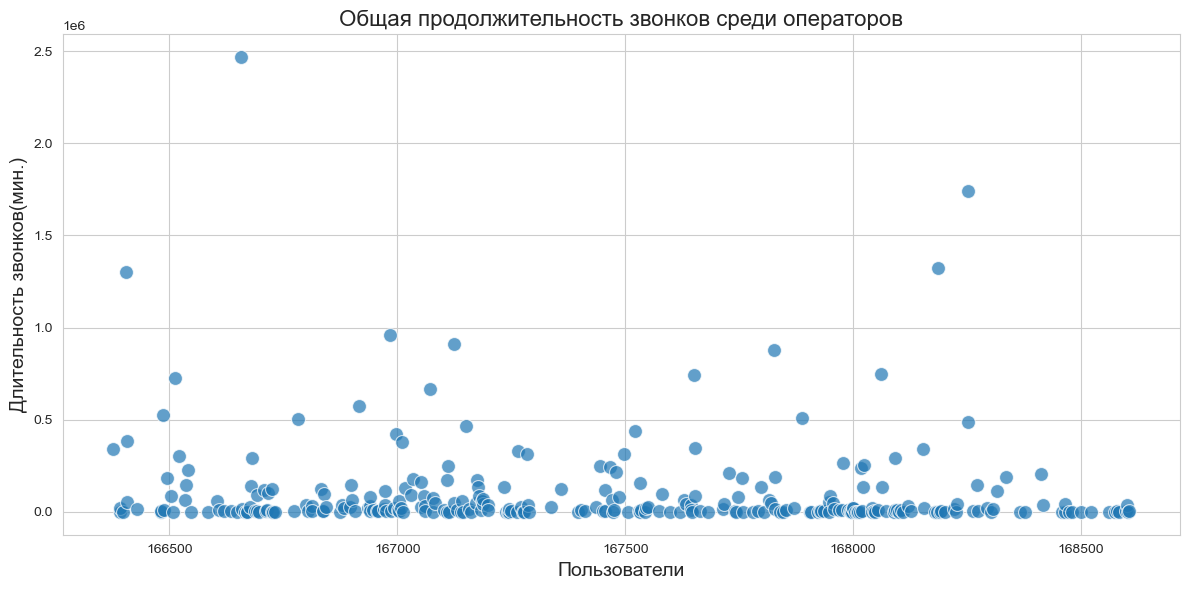

In [260]:
# Формирование свода данных
telecom_hours = filtered_telecom_two.pivot_table(
    index=['user_id'],
    values='total_call_duration',
    aggfunc='sum'  # агрегирующая функция - суммируем total_call_duration
).reset_index()

# Настройка стиля графика
sns.set_style("whitegrid")

# Создание графика
fig, ax = plt.subplots(figsize=(12, 6))  # Увеличенный размер окна

# Plot с использованием Seaborn
sns.scatterplot(x="user_id", y="total_call_duration", data=telecom_hours, s=100, alpha=0.7)

# Заголовок и метки осей
ax.set_title('Общая продолжительность звонков среди операторов', fontsize=16)
ax.set_xlabel('Пользователи', fontsize=14)
ax.set_ylabel('Длительность звонков(мин.)', fontsize=14)

# Сохранение фигуры
plt.tight_layout()
plt.show()

In [80]:
telecom_hours.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284 entries, 0 to 283
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   user_id              284 non-null    int64
 1   total_call_duration  284 non-null    int64
dtypes: int64(2)
memory usage: 4.6 KB


In [81]:
round(telecom_hours['total_call_duration'].describe(),1)

count        284.0
mean      106399.6
std       255534.7
min           11.0
25%         2223.8
50%        14182.5
75%        89833.5
max      2467500.0
Name: total_call_duration, dtype: float64

75% пользователей имеют общую длительность звонков до 89,833 минут. Имеется большое количество выбросов. Максимальная длительность звонков у одного пользователя - 646,593 минут. Для фильтрации определим границы: нижняя граница - 1-й процентиль(0.005), верхняя граница - 99-й процентиль(0.995). 

In [83]:
# Определение нижнего и верхнего квантилей (0.5% и 99.5%)
q_low_two = telecom_hours['total_call_duration'].quantile(0.005)
q_high_two = telecom_hours['total_call_duration'].quantile(0.995)

# Фильтрация данных: остаются только те, кто попадает в указанный диапазон
telecom_hours_filtered = telecom_hours[(telecom_hours['total_call_duration'] >= q_low_two) & (telecom_hours['total_call_duration'] <= q_high_two)]

# Вывод общей информации
telecom_hours_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 280 entries, 0 to 283
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   user_id              280 non-null    int64
 1   total_call_duration  280 non-null    int64
dtypes: int64(2)
memory usage: 6.6 KB


In [84]:
# Фильтрация telecom по списку операторов из telecom_calls_sum_filtered
filtered_telecom_three = filtered_telecom_two[
    filtered_telecom_two['user_id'].isin(telecom_hours_filtered['user_id'])
]

# Просмотр первых нескольких строк нового фильтрационного набора
filtered_telecom_three.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24419 entries, 3 to 48890
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              24419 non-null  int64         
 1   date                 24419 non-null  datetime64[ns]
 2   direction            24419 non-null  object        
 3   internal             24419 non-null  bool          
 4   operator_id          24419 non-null  int32         
 5   is_missed_call       24419 non-null  bool          
 6   calls_count          24419 non-null  int64         
 7   call_duration        24419 non-null  int64         
 8   total_call_duration  24419 non-null  int64         
 9   tariff_plan          24419 non-null  object        
 10  date_start           24419 non-null  datetime64[ns]
 11  cur_monthly_fee      24419 non-null  int64         
 12  month                24419 non-null  int32         
dtypes: bool(2), datetime64[ns](2), int32

In [85]:
# Получаем количество строк в каждом датафрейме
rows_filtered_telecom_three = len(filtered_telecom_three)

# Определяем больший и меньший датафреймы
bigger_rows = max(rows_filtered_telecom_two, rows_filtered_telecom_three)
smaller_rows = min(rows_filtered_telecom_two, rows_filtered_telecom_three)

# Вычисляем процент
percentage_difference = (1-smaller_rows / bigger_rows) * 100

# Выводим результат
print(f"Количество строк отфильтрованного датафрейма на {percentage_difference:.2f}% меньше датафрейма до фильтрации.")

Количество строк отфильтрованного датафрейма на 6.16% меньше датафрейма до фильтрации.


### Проанализируем количество исходящих звонков по месяцам

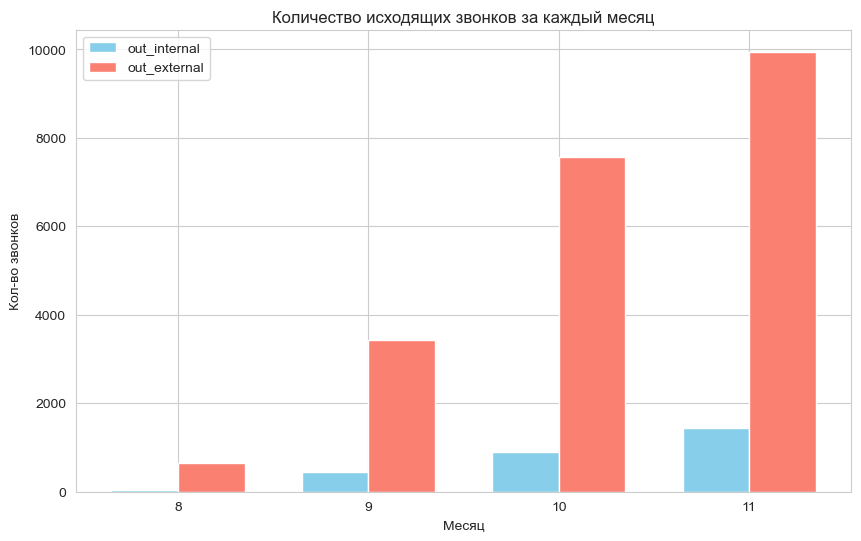

In [87]:
# Заводим константу
CONSTANT_TWO = 2

outgoing_internal_and_external_calls_monthly = filtered_telecom_three.pivot_table(
    index=['month','internal'],
    values='calls_count',
    aggfunc='count'  # агрегирующая функция - суммируем total_call_duration
).reset_index()

months = outgoing_internal_and_external_calls_monthly['month'].unique()
out_internal = outgoing_internal_and_external_calls_monthly.loc[outgoing_internal_and_external_calls_monthly['internal'] == True]['calls_count']
out_external = outgoing_internal_and_external_calls_monthly.loc[outgoing_internal_and_external_calls_monthly['internal'] == False]['calls_count']

x = range(len(months))
width = 0.35  # Ширина столбиков

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x, out_internal, width=width, label='out_internal', color='skyblue')
ax.bar([i + width for i in x], out_external, width=width, label='out_external', color='salmon')

ax.set_xlabel('Месяц')
ax.set_ylabel('Кол-во звонков')
ax.set_title('Количество исходящих звонков за каждый месяц')
ax.set_xticks([i + width / CONSTANT_TWO for i in x])
ax.set_xticklabels(months)
ax.legend()

plt.show()

Количество исходящих звонков(внутри и вне сети) постоянно растет. Резкий рост замедляется на 4-м месяце. Доля исходящих звонков внутри сети незначительная.

### Проанализируем общую продолжительность исходящих звонков по месяцам

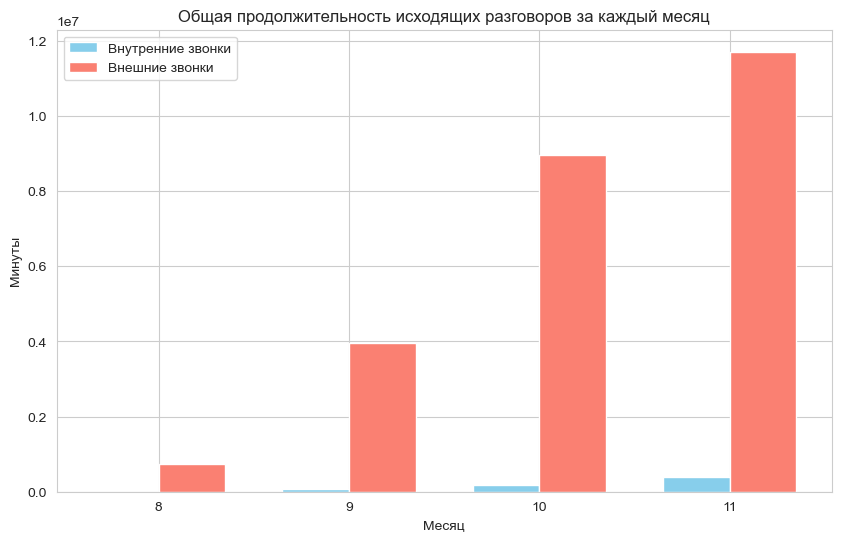

In [90]:
# Строим таблицу с общей продолжительностью звонков по месяцам и типу звонка
outgoing_internal_and_external_calls_total_duration_monthly = filtered_telecom_three.pivot_table(
    index=['month', 'internal'],
    values='total_call_duration',
    aggfunc='sum'
).reset_index()

# Получаем список уникальных месяцев
months = outgoing_internal_and_external_calls_total_duration_monthly['month'].unique()

# Извлекаем данные по внутреннему и внешнему направлению звонков
out_internal = outgoing_internal_and_external_calls_total_duration_monthly.query("internal == True").set_index('month')['total_call_duration']
out_external = outgoing_internal_and_external_calls_total_duration_monthly.query("internal == False").set_index('month')['total_call_duration']

# Определяем ширину столбиков
x = range(len(months))
width = 0.35

# Создаем фигуру и ось
fig, ax = plt.subplots(figsize=(10, 6))

# Рисуем столбики
ax.bar(x, out_internal, width=width, label='Внутренние звонки', color='skyblue')
ax.bar([i + width for i in x], out_external, width=width, label='Внешние звонки', color='salmon')

# Подписываем оси и добавляем заголовок
ax.set_xlabel('Месяц')
ax.set_ylabel('Минуты')  # Исправили название оси Y
ax.set_title('Общая продолжительность исходящих разговоров за каждый месяц')

# Устанавливаем метки месяцев на оси X
ax.set_xticks([i + width / CONSTANT_TWO for i in x])
ax.set_xticklabels(months)

# Отображаем легенду
ax.legend()

# Показываем график
plt.show()

Аналогичная ситуация на этом графике: каждый месяц имеется значительный прирост. Рост замедляется(стабилизируется) на 4-м месяце. Доля звонков внутри сети минимальная.

### Построим график распределения абонентов по тарифным планам помесячно

In [93]:
# Выделяем уникальные комбинации месяца, тарифного плана и идентификатора пользователя
unique_users_per_month_and_plan = filtered_telecom_three.drop_duplicates(subset=['month', 'tariff_plan', 'user_id'])

# Формируем pivot table с количеством уникальных пользователей
users_grouped_monthly_by_tariff_plan = unique_users_per_month_and_plan.pivot_table(
    index=['month', 'tariff_plan'],          # Индексирование по двум параметрам
    values='user_id',                        # Значением является идентификатор пользователя
    aggfunc='count',                         # Агрегируем путем подсчета
    fill_value=0                             # Заполняем отсутствующие значения нулями
).reset_index().rename(columns={'user_id': 'count'})  # Переименовываем столбец с числом пользователей

# Выведем первые строки
users_grouped_monthly_by_tariff_plan.head(3)

,month,tariff_plan,count
0,8,A,8
1,8,B,25
2,8,C,30


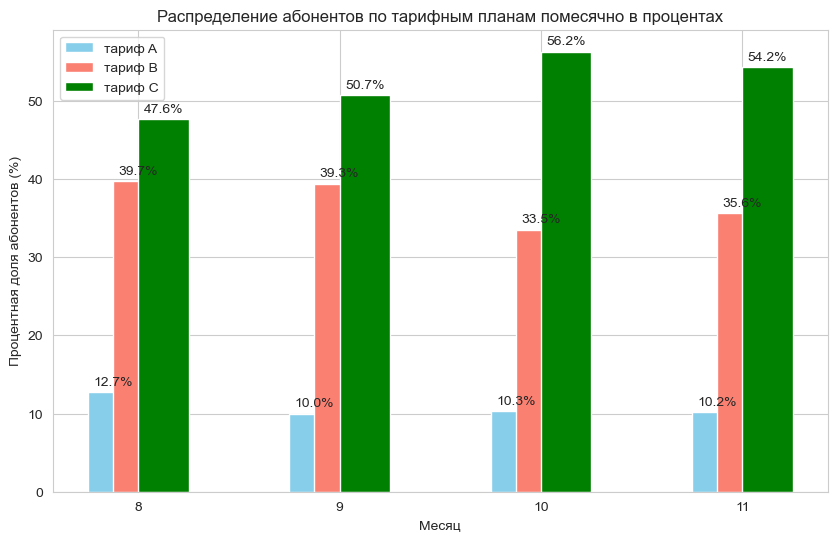

In [94]:
# Группируем данные по месяцам и тарифам
grouped_data = users_grouped_monthly_by_tariff_plan.pivot(index='month', columns='tariff_plan', values='count').fillna(0)

# Суммируем всех пользователей по месяцам
total_users_per_month = grouped_data.sum(axis=1)

# Переводим абсолютные значения в проценты для каждого месяца
percentages = grouped_data.divide(total_users_per_month, axis=0).multiply(100)

# Настройка ширины столбца
x = range(len(months))
width = 0.25

# Создание рисунка и осей
fig, ax = plt.subplots(figsize=(10, 6))

# Отображение бар-чартов с процентами
bar_A = ax.bar([i - width/2 for i in x], percentages['A'], width=width, label='тариф A', color='skyblue')
bar_B = ax.bar(x, percentages['B'], width=width, label='тариф B', color='salmon')
bar_C = ax.bar([i + width/2 for i in x], percentages['C'], width=width, label='тариф C', color='green')

# Функция для вывода подписей поверх столбцов
def add_percentage_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')

# Добавляем подписи на график
add_percentage_labels(bar_A)
add_percentage_labels(bar_B)
add_percentage_labels(bar_C)

# Подписываем оси и задаём название графика
ax.set_xlabel('Месяц')
ax.set_ylabel('Процентная доля абонентов (%)')
ax.set_title('Распределение абонентов по тарифным планам помесячно в процентах')

# Установка меток месяцев на оси Х
ax.set_xticks(x)
ax.set_xticklabels(months)

# Легенда
ax.legend()

# Показываем график
plt.show()

- Доля клиентов с тарифными планоми А и B практически не меняется от месяца к месяцу
- Доля клиентов с тарифным планом C постепенно растет первые три месяца

### Разделим клиентов на активных и неактивных

#### Выделим активными клиентами тех пользователей услуг, которые присутствуют в датасете в ноябре.

In [98]:
# Заводим константу
LAST_MONTH_CONSTANT = 11

# находим клиентов, последний месяц активности которых не равен 11
last__month_active_users = filtered_telecom_three.groupby('user_id')['month'].max().reset_index()
inactive_users = last__month_active_users[last__month_active_users['month'] != LAST_MONTH_CONSTANT].reset_index(drop=True)

# Выведем первые три строки
inactive_users.head(3)

,user_id,month
0,166399,10
1,166507,8
2,166533,10


In [99]:
# Фильтрация filtered_telecom_three по списку операторов из inactive_users
filtered_telecom_four = filtered_telecom_three[~filtered_telecom_three['user_id'].isin(inactive_users['user_id'])]

# Просмотр первых нескольких строк нового фильтрационного набора
filtered_telecom_four.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23329 entries, 3 to 48890
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              23329 non-null  int64         
 1   date                 23329 non-null  datetime64[ns]
 2   direction            23329 non-null  object        
 3   internal             23329 non-null  bool          
 4   operator_id          23329 non-null  int32         
 5   is_missed_call       23329 non-null  bool          
 6   calls_count          23329 non-null  int64         
 7   call_duration        23329 non-null  int64         
 8   total_call_duration  23329 non-null  int64         
 9   tariff_plan          23329 non-null  object        
 10  date_start           23329 non-null  datetime64[ns]
 11  cur_monthly_fee      23329 non-null  int64         
 12  month                23329 non-null  int32         
dtypes: bool(2), datetime64[ns](2), int32

In [100]:
# Получаем количество строк в каждом датафрейме
rows_filtered_telecom_four = len(filtered_telecom_four)

# Определяем больший и меньший датафреймы
bigger_rows = max(rows_filtered_telecom_three, rows_filtered_telecom_four)
smaller_rows = min(rows_filtered_telecom_three, rows_filtered_telecom_four)

# Вычисляем процент
percentage_difference = (1-smaller_rows / bigger_rows) * 100

# Выводим результат
print(f"Количество строк отфильтрованного датафрейма на {percentage_difference:.2f}% меньше датафрейма до фильтрации.")

Количество строк отфильтрованного датафрейма на 4.46% меньше датафрейма до фильтрации.


Мы отфильтровали 1,090(4.5%) записей с неактивными пользователями. Остальных всех пользователей будем считать активными. 

#### Построим графики распределений клиентов по тарифным планам

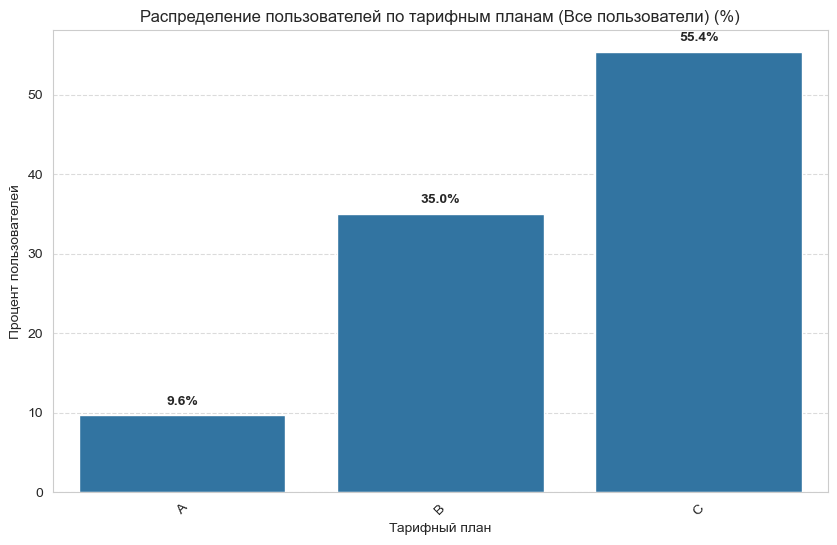

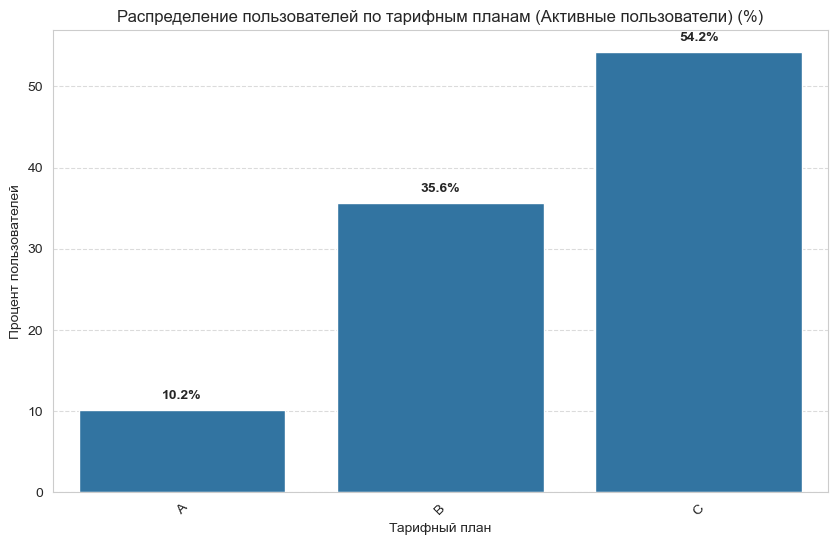

In [268]:
datasets = [(filtered_telecom_three, 'Все пользователи'),
            (filtered_telecom_four, 'Активные пользователи')]

# Функция для построения графика распределения
def build_user_distribution_plot(df, title):
    """
    Функция принимает DataFrame и заголовок, возвращает график распределения пользователей по тарифам.
    """
    # Подсчет уникальных пользователей по тарифным планам
    users_per_tariff = df.groupby('tariff_plan')['user_id'].nunique().reset_index()
    
    # Общее количество уникальных пользователей
    total_users = users_per_tariff['user_id'].sum()
    
    # Расчет долей пользователей для каждого тарифного плана
    users_per_tariff['percentage'] = users_per_tariff['user_id'] / total_users * 100
    
    # Рисуем график
    plt.figure(figsize=(10, 6))
    sns.barplot(x='tariff_plan', y='percentage', data=users_per_tariff)
    
    # Оформляем график
    plt.title(f'Распределение пользователей по тарифным планам ({title}) (%)')
    plt.xlabel('Тарифный план')
    plt.ylabel('Процент пользователей')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Аннотируем значения процентов над столбцами
    for i, row in users_per_tariff.iterrows():
        plt.text(i, row['percentage']+1, f"{row['percentage']:.1f}%",
                 ha='center', va='bottom', fontweight='bold')
        
    plt.show()

# Применяем функцию к обоим датасетам
for dataset, title in datasets:
    build_user_distribution_plot(dataset, title)

In [104]:
# Подсчет уникальных пользователей по тарифным планам
users_per_tariff = filtered_telecom_three.groupby('tariff_plan')['user_id'].nunique().reset_index()
active_users_per_tariff = filtered_telecom_four.groupby('tariff_plan')['user_id'].nunique().reset_index()

# Предположим, что у вас уже определены DataFrames users_per_tariff и active_users_per_tariff
total_users = users_per_tariff['user_id'].sum()
active_users = active_users_per_tariff['user_id'].sum()

print(f"Общее количество пользователей - {total_users}.")
print(f"Общее количество активных пользователей - {active_users}.")

Общее количество пользователей - 280.
Общее количество активных пользователей - 236.


Доли активных пользователей остались примерно на том же уровне что и в основном датасете. Наша выборка - репрезентативная. Общее количество активных пользователей меньше на 44(15.7%) единицы.

Мы провели исследовательский анализ данных:
- Вычислили границы анализуемого периода: начало периода: 2019-08-02,конец периода: 2019-11-28. То есть в августе не хватает одного дня, в ноябре - двух. При этом, самый большой трафик приходится на ноябрь, поэтому мы решили не редактировать(урезать) ноябрьские данные, так как мы можем потерять ценную информацию для принятия решения по переводу активных клиентов на новый тариф.
- Мы построили график распределения количества звонков по датам. Количество звонков растет.
- Проанализировали соотношение входящих и исходящих звонков. Распределение примерно одинаковое. При этом, входящих звонков больше. Они бесплатные. Но клиенты, которые используют только входящие звонки, платят ежемесячную абонентскую плату плюс за каждого оператора. Мы не стали их удалаять.
- Посчитали количество пропущенных звонков. Было обнаружено довольно много пропущенных вызовов(43.8%). Они нам не нужны для дальнейших расчетов. Мы их удалали
- Проанализировали общее количество звонков среди клиентов. В 75% случаях на одного клиента приходится до 869 звонка. Имеется большое количество выбросов. Самое большое количество - 83,276 звонков. Для фильтрации определили границы: нижняя граница - 1-й процентиль(0.01), верхняя граница - 99-й процентиль(0.99). Такой подход оставляет ещё меньше экстремумов, оставляя лишь самые центрированные данные. Мы отфильтровали датасет по количеству звонков: убрали всех клиентов(5.36% от всех записей), у которых суммарное количество звонков больше 15,852 штук.
- Проанализировали общую длительность звонков. 75% пользователей имеют общую длительность звонков до 89,833 минут. Имеется большое количество выбросов. Максимальная длительность звонков у одного пользователя - 646,593 минут. Для фильтрации определим границы: нижняя граница - 1-й процентиль(0.005), верхняя граница - 99-й процентиль(0.995). Мы отфильтровали 6.16%.
- Проанализировали количество исходящих звонков по месяцам. Количество исходящих звонков(внутри и вне сети) постоянно растет. Резкий рост замедляется на 4-м месяце. Доля исходящих звонков внутри сети незначительная.
- Проанализировали общую продолжительность исходящих звонков по месяцам. Аналогичная ситуация на этом графике: каждый месяц имеется значительный прирост. Рост замедляется(стабилизируется) на 4-м месяце. Доля звонков внутри сети минимальная.
- Построили графики распределения абонентов по тарифным планам:
  - Доля клиентов с тарифными планоми А и B практически не меняется от месяца к месяцу
  - Доля клиентов с тарифным планом C постепенно растет первые три месяца
- Разделили клиентов на активных и неактивных:
  - Выделили активными клиентами тех пользователей услуг, которые присутствуют в датасете в ноябре. Мы отфильтровали 1,090(4.5%) записей с неактивными пользователями. Остальных всех пользователей будем считать активными.
  - Построили графики распределений пользователей по тарифным планам: по всем пользователям и отдельно по активным. Доли активных пользователей остались примерно на том же уровне что и в основном датасете. Наша выборка - репрезентативная. Общее количество активных пользователей меньше на 44(15.7%) единицы.


## 4  Посчитаем расходы на исходящие звонки, общие расходы и потенциальную экономию

### Посчитаем количество операторов для каждого клиента помесячно, отфильтруем исходящие звонки и столбцы из главной таблицы, которые не нужны для данного расчета

In [109]:
# Группа по user_id и month, считаем уникальные операторы
number_of_operators_per_month = filtered_telecom_four.groupby(['user_id', 'month'])['operator_id'].nunique().reset_index(name='num_of_operators')
# Объединение с основным датасетом
filtered_telecom_five = filtered_telecom_four.merge(number_of_operators_per_month, on=['user_id', 'month'])


# Фильтрация по нужным условиям
outgoing_calls = filtered_telecom_five[(filtered_telecom_five['direction'] == 'out')]

# Копируем dataframe для дальнейших манипуляций
outgoing_calls = outgoing_calls.copy()

# Удаляем ненужные столбцы
outgoing_calls.drop(columns=['date','direction','operator_id','is_missed_call','calls_count','call_duration','date_start'], inplace=True)

# Выведем первые строчки нового датасета
outgoing_calls.head(3)

,user_id,internal,total_call_duration,tariff_plan,cur_monthly_fee,month,num_of_operators
0,166377,True,18,B,2000,8,4
1,166377,False,29,B,2000,8,4
2,166377,False,819,B,2000,8,4


### Посчитаем расходы на исходящие звонки внутри сети

Соберем общую продолжительность исходящих звонков внутри сети по клиентам помесячно

In [112]:
# Фильтрация по нужным условиям
outgoing_calls_inside_net = outgoing_calls[(outgoing_calls['internal'] == True)]

# Новый группировочный список с добавлением tariff_plan
outgoing_calls_inside_net_total_min = outgoing_calls_inside_net.groupby(['user_id', 'month', 'tariff_plan','num_of_operators'])['total_call_duration'].sum().reset_index()

# Выведем первые строки
outgoing_calls_inside_net_total_min.tail(3)

,user_id,month,tariff_plan,num_of_operators,total_call_duration
128,168336,11,C,11,2796
129,168500,11,B,1,30
130,168606,11,C,1,3716


Посчитаем ежемсячные расходы на исходящие звонки внутри сети по каждому клиенту и тарифу

In [114]:
# Определим константы для расчетов
CONSTANT_MIN_MINS = 2000  # Базовые минуты, включённые в пакет тарифа
COEFF_OUTGOING_CALLS_INSIDE_NET_A = 0.1  # Тариф А: стоимость минут сверх лимита
COEFF_OUTGOING_CALLS_INSIDE_NET_B = 0.15  # Тариф Б: стоимость минут сверх лимита
COEFF_OUTGOING_CALLS_INSIDE_NET_C = 0.30  # Тариф С: стоимость минут сверх лимита


# Функция для расчета стоимости звонков исходя из текущего пакета
def calculate_cost(row, rate):
    """
    Расчет стоимости звонков.
    
    Если общее количество минут меньше базовых минут, стоимость равна нулю.
    Иначе рассчитывается плата за превышение лимитированных минут.
    """
    if row['total_call_duration'] <= CONSTANT_MIN_MINS:
        return 0
    else:
        excess_minutes = row['total_call_duration'] - CONSTANT_MIN_MINS
        return excess_minutes * rate


# Создание копии исходного DataFrame для хранения результатов
outgoing_calls_inside_net_monthly_total_cost = outgoing_calls_inside_net_total_min.copy()

# Применение правил расчета стоимости звонков в зависимости от тарифного плана
outgoing_calls_inside_net_monthly_total_cost['tc_inside_net_calls_tariff_cur'] = outgoing_calls_inside_net_monthly_total_cost.apply(
    lambda x: calculate_cost(x, COEFF_OUTGOING_CALLS_INSIDE_NET_A) if x['tariff_plan'] == 'A' else
              calculate_cost(x, COEFF_OUTGOING_CALLS_INSIDE_NET_B) if x['tariff_plan'] == 'B' else
              calculate_cost(x, COEFF_OUTGOING_CALLS_INSIDE_NET_C),
    axis=1
)

# Дополнительно рассчитываем стоимость звонков для каждого тарифного плана отдельно
outgoing_calls_inside_net_monthly_total_cost['tc_inside_net_calls_tariff_a'] = outgoing_calls_inside_net_monthly_total_cost.apply(
    lambda x: calculate_cost(x, COEFF_OUTGOING_CALLS_INSIDE_NET_A),
    axis=1
)

outgoing_calls_inside_net_monthly_total_cost['tc_inside_net_calls_tariff_b'] = outgoing_calls_inside_net_monthly_total_cost.apply(
    lambda x: calculate_cost(x, COEFF_OUTGOING_CALLS_INSIDE_NET_B),
    axis=1
)

outgoing_calls_inside_net_monthly_total_cost['tc_inside_net_calls_tariff_c'] = outgoing_calls_inside_net_monthly_total_cost.apply(
    lambda x: calculate_cost(x, COEFF_OUTGOING_CALLS_INSIDE_NET_C),
    axis=1
)

# Удаляем ненужный столбец total_call_duration
outgoing_calls_inside_net_monthly_total_cost.drop(columns=['total_call_duration'], inplace=True)

# Выведем первые три строки
outgoing_calls_inside_net_monthly_total_cost.tail(3)

,user_id,month,tariff_plan,num_of_operators,tc_inside_net_calls_tariff_cur,tc_inside_net_calls_tariff_a,tc_inside_net_calls_tariff_b,tc_inside_net_calls_tariff_c
128,168336,11,C,11,238.8,79.6,119.4,238.8
129,168500,11,B,1,0.0,0.0,0.0,0.0
130,168606,11,C,1,514.8,171.6,257.4,514.8


### Посчитаем расходы клиентов на исходящие звонки вне сети 

Посчитаем исходящие звонки вне сети по каждой записи из датасета

In [117]:
# Фильтрация по нужным условиям
outgoing_calls_outside_net = outgoing_calls[(outgoing_calls['internal'] == False)]

# Копируем dataframe для дальнейших манипуляций
outgoing_calls_outside_net = outgoing_calls_outside_net.copy()

# Коэффициенты стоимости звонков вне своей сети по тарифам
COEFF_OUTGOING_CALLS_OUTSIDE_NET_A = 0.4  # Тариф А: стоимость минуты вне сети
COEFF_OUTGOING_CALLS_OUTSIDE_NET_B = 0.5  # Тариф Б: стоимость минуты вне сети
COEFF_OUTGOING_CALLS_OUTSIDE_NET_C = 0.7  # Тариф С: стоимость минуты вне сети

# Функция для расчета стоимости звонков вне своей сети
def calculate_outside_network_cost(row, tariff):
    """
    Рассчитывает стоимость звонков вне сети, исходя из указанного тарифного плана.
    :param row: Строка DataFrame с информацией о звонке
    :param tariff: Текущий тарифный план ('A', 'B' или 'C')
    :return: Стоимость звонка вне сети
    """
    cost_per_minute = {
        'A': COEFF_OUTGOING_CALLS_OUTSIDE_NET_A,
        'B': COEFF_OUTGOING_CALLS_OUTSIDE_NET_B,
        'C': COEFF_OUTGOING_CALLS_OUTSIDE_NET_C
    }.get(tariff, 0)
        
    return round(cost_per_minute * row['total_call_duration'], 2)

# Применение функции для расчета стоимости звонков вне сети по каждому тарифному плану
outgoing_calls_outside_net['outside_net_calls_cost_tariff_cur'] = outgoing_calls_outside_net.apply(
    lambda row: calculate_outside_network_cost(row, row['tariff_plan']),
    axis=1
)

outgoing_calls_outside_net['outside_net_calls_cost_tariff_a'] = outgoing_calls_outside_net.apply(
    lambda row: calculate_outside_network_cost(row, 'A'),
    axis=1
)

outgoing_calls_outside_net['outside_net_calls_cost_tariff_b'] = outgoing_calls_outside_net.apply(
    lambda row: calculate_outside_network_cost(row, 'B'),
    axis=1
)

outgoing_calls_outside_net['outside_net_calls_cost_tariff_c'] = outgoing_calls_outside_net.apply(
    lambda row: calculate_outside_network_cost(row, 'C'),
    axis=1
)

# Удаляем ненужный столбец total_call_duration
outgoing_calls_outside_net.drop(columns=['internal','total_call_duration'], inplace=True)

# Выведем первые три строки
outgoing_calls_outside_net.head(3)

,user_id,tariff_plan,cur_monthly_fee,month,num_of_operators,outside_net_calls_cost_tariff_cur,outside_net_calls_cost_tariff_a,outside_net_calls_cost_tariff_b,outside_net_calls_cost_tariff_c
1,166377,B,2000,8,4,14.5,11.6,14.5,20.3
2,166377,B,2000,8,4,409.5,327.6,409.5,573.3
3,166377,B,2000,8,4,14.0,11.2,14.0,19.6


Сгруппируем данные помесячно

In [119]:
# Группировка и агрегация данных
outgoing_calls_outside_net_monthly_total_cost = outgoing_calls_outside_net.groupby(['user_id', 'month'])[
    ['outside_net_calls_cost_tariff_cur', 'outside_net_calls_cost_tariff_a', 'outside_net_calls_cost_tariff_b', 'outside_net_calls_cost_tariff_c','num_of_operators', 'cur_monthly_fee', 'tariff_plan',]
].agg({
    'cur_monthly_fee': 'first',
    'tariff_plan': 'first',
    'num_of_operators': 'first',
    'outside_net_calls_cost_tariff_cur': 'sum',
    'outside_net_calls_cost_tariff_a': 'sum',
    'outside_net_calls_cost_tariff_b': 'sum',
    'outside_net_calls_cost_tariff_c': 'sum'
}).reset_index()

# Правильное переименование столбцов
outgoing_calls_outside_net_monthly_total_cost.rename(columns={
    'outside_net_calls_cost_tariff_cur': 'tc_outside_net_calls_tariff_cur',  
    'outside_net_calls_cost_tariff_a': 'tc_outside_net_calls_tariff_a',       
    'outside_net_calls_cost_tariff_b': 'tc_outside_net_calls_tariff_b',       
    'outside_net_calls_cost_tariff_c': 'tc_outside_net_calls_tariff_c'        
}, inplace=True)

# Выведем первые три строки
outgoing_calls_outside_net_monthly_total_cost.head(3)

,user_id,month,cur_monthly_fee,tariff_plan,num_of_operators,tc_outside_net_calls_tariff_cur,tc_outside_net_calls_tariff_a,tc_outside_net_calls_tariff_b,tc_outside_net_calls_tariff_c
0,166377,8,2000,B,4,34550.0,27640.0,34550.0,48370.0
1,166377,9,2000,B,4,45943.0,36754.4,45943.0,64320.2
2,166377,10,2000,B,5,44251.0,35400.8,44251.0,61951.4


### Посчитаем суммарные расходы по каждому тарифу в разрезе пользователей помесячно

Объединим два датасета: ежемесячные расходы по исходящим внутри и вне сети

In [122]:
# Операция слияния (объединение) по двум ключевым полям: user_id и month
outgoing_calls_inside_outside_net_monthly_total_cost = outgoing_calls_outside_net_monthly_total_cost.merge(outgoing_calls_inside_net_monthly_total_cost, on=['user_id', 'month', 'tariff_plan','num_of_operators'], how='left')

# Выводим первые строки
outgoing_calls_inside_outside_net_monthly_total_cost.head(3)

,user_id,month,cur_monthly_fee,tariff_plan,num_of_operators,tc_outside_net_calls_tariff_cur,tc_outside_net_calls_tariff_a,tc_outside_net_calls_tariff_b,tc_outside_net_calls_tariff_c,tc_inside_net_calls_tariff_cur,tc_inside_net_calls_tariff_a,tc_inside_net_calls_tariff_b,tc_inside_net_calls_tariff_c
0,166377,8,2000,B,4,34550.0,27640.0,34550.0,48370.0,0.0,0.0,0.0,0.0
1,166377,9,2000,B,4,45943.0,36754.4,45943.0,64320.2,NaN,NaN,NaN,NaN
2,166377,10,2000,B,5,44251.0,35400.8,44251.0,61951.4,0.0,0.0,0.0,0.0


In [123]:
outgoing_calls_inside_outside_net_monthly_total_cost.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402 entries, 0 to 401
Data columns (total 13 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   user_id                          402 non-null    int64  
 1   month                            402 non-null    int32  
 2   cur_monthly_fee                  402 non-null    int64  
 3   tariff_plan                      402 non-null    object 
 4   num_of_operators                 402 non-null    int64  
 5   tc_outside_net_calls_tariff_cur  402 non-null    float64
 6   tc_outside_net_calls_tariff_a    402 non-null    float64
 7   tc_outside_net_calls_tariff_b    402 non-null    float64
 8   tc_outside_net_calls_tariff_c    402 non-null    float64
 9   tc_inside_net_calls_tariff_cur   123 non-null    float64
 10  tc_inside_net_calls_tariff_a     123 non-null    float64
 11  tc_inside_net_calls_tariff_b     123 non-null    float64
 12  tc_inside_net_calls_ta

Заменим значения NaN в столбцах tc_inside_net_calls_tariff_cur, tc_inside_net_calls_tariff_a, tc_inside_net_calls_tariff_b, tc_inside_net_calls_tariff_c на 0

In [125]:
# Список столбцов, в которых нужно заменить NaN на 0
columns_to_fill = ['tc_inside_net_calls_tariff_cur', 'tc_inside_net_calls_tariff_a', 'tc_inside_net_calls_tariff_b', 'tc_inside_net_calls_tariff_c']

# Заполнение NaN значениями 0
outgoing_calls_inside_outside_net_monthly_total_cost[columns_to_fill] = outgoing_calls_inside_outside_net_monthly_total_cost[columns_to_fill].fillna(0)

# Выводим первые строки
outgoing_calls_inside_outside_net_monthly_total_cost.head(3)

,user_id,month,cur_monthly_fee,tariff_plan,num_of_operators,tc_outside_net_calls_tariff_cur,tc_outside_net_calls_tariff_a,tc_outside_net_calls_tariff_b,tc_outside_net_calls_tariff_c,tc_inside_net_calls_tariff_cur,tc_inside_net_calls_tariff_a,tc_inside_net_calls_tariff_b,tc_inside_net_calls_tariff_c
0,166377,8,2000,B,4,34550.0,27640.0,34550.0,48370.0,0.0,0.0,0.0,0.0
1,166377,9,2000,B,4,45943.0,36754.4,45943.0,64320.2,0.0,0.0,0.0,0.0
2,166377,10,2000,B,5,44251.0,35400.8,44251.0,61951.4,0.0,0.0,0.0,0.0


Считаем суммарные ежемесячные расходы

In [127]:
# Коэффициенты стоимости звонков вне своей сети по тарифам
ONE_OPERATOR_COST_A = 50  # Тариф А: цена одного оператора
ONE_OPERATOR_COST_B = 150  # Тариф Б: цена одного оператора
ONE_OPERATOR_COST_C = 300  # Тариф С: цена одного оператора

# Определение коэффициентов в зависимости от тарифного плана
coefficients = {'A': ONE_OPERATOR_COST_A, 'B': ONE_OPERATOR_COST_B, 'C': ONE_OPERATOR_COST_C}

# Преобразование условий и создание новых столбцов
for index, row in outgoing_calls_inside_outside_net_monthly_total_cost.iterrows():
    coefficient = coefficients[row['tariff_plan']] * row['num_of_operators']
    
    # Перерассчёт столбцов с учётом new_coefficient
    outgoing_calls_inside_outside_net_monthly_total_cost.at[index, 'tc_tariff_cur'] = row['cur_monthly_fee'] + row['tc_outside_net_calls_tariff_cur'] + row['tc_inside_net_calls_tariff_cur'] + coefficient
    outgoing_calls_inside_outside_net_monthly_total_cost.at[index, 'tc_tariff_a'] = MONTHLY_FEE_TARIFF_A + row['tc_outside_net_calls_tariff_a'] + row['tc_inside_net_calls_tariff_a'] + ONE_OPERATOR_COST_A * row['num_of_operators']
    outgoing_calls_inside_outside_net_monthly_total_cost.at[index, 'tc_tariff_b'] = MONTHLY_FEE_TARIFF_B + row['tc_outside_net_calls_tariff_b'] + row['tc_inside_net_calls_tariff_b'] + ONE_OPERATOR_COST_B * row['num_of_operators']
    outgoing_calls_inside_outside_net_monthly_total_cost.at[index, 'tc_tariff_c'] = MONTHLY_FEE_TARIFF_C + row['tc_outside_net_calls_tariff_c'] + row['tc_inside_net_calls_tariff_c'] + ONE_OPERATOR_COST_C * row['num_of_operators']

# Сохраняем нужный набор столбцов
total_monthly_costs_per_user = outgoing_calls_inside_outside_net_monthly_total_cost[
    ['user_id', 'month','tariff_plan', 'tc_tariff_cur', 'tc_tariff_a', 'tc_tariff_b', 'tc_tariff_c']
]

# Выведем первые три строки
total_monthly_costs_per_user.head(3)

,user_id,month,tariff_plan,tc_tariff_cur,tc_tariff_a,tc_tariff_b,tc_tariff_c
0,166377,8,B,37150.0,32840.0,37150.0,50570.0
1,166377,9,B,48543.0,41954.4,48543.0,66520.2
2,166377,10,B,47001.0,40650.8,47001.0,64451.4


### Посчитаем общую возможную экономию для клиентов за 4 месяца

Посчитаем потенциальную общую среднемесячную экономию для клиентов

In [130]:
# Основной DataFrame
monthly_costs_and_potential_savings = pd.DataFrame(total_monthly_costs_per_user)


# Создание столбца potential_savings
def compute_potential_savings(row):
    cur_tariff = row['tc_tariff_cur']
    other_tariffs = [row['tc_tariff_a'], row['tc_tariff_b'], row['tc_tariff_c']]
    min_tariff = min(other_tariffs)
    
    if cur_tariff == min_tariff:
        return 0
    elif cur_tariff > min_tariff:
        return cur_tariff - min_tariff
    
    
    elif cur_tariff in other_tariffs:
        return cur_tariff - min_tariff
    else:
        return None  # Или другое подходящее значение, если хотите пропустить такие случаи

# Применяем функцию к каждой строке
monthly_costs_and_potential_savings['potential_savings'] = monthly_costs_and_potential_savings.apply(compute_potential_savings, axis=1)

# Выведем первые три строки
monthly_costs_and_potential_savings.head(3)

,user_id,month,tariff_plan,tc_tariff_cur,tc_tariff_a,tc_tariff_b,tc_tariff_c,potential_savings
0,166377,8,B,37150.0,32840.0,37150.0,50570.0,4310.0
1,166377,9,B,48543.0,41954.4,48543.0,66520.2,6588.6
2,166377,10,B,47001.0,40650.8,47001.0,64451.4,6350.2


In [131]:
# Подсчет общей суммы потенциальных сбережений
total_savings = f"{monthly_costs_and_potential_savings['potential_savings'].sum()}"

# Подсчет текущей средней ежемесячной выручки
current_turnover = f"{monthly_costs_and_potential_savings['tc_tariff_cur'].sum()}"

print(f'Общая выручка за 4 месяца: {current_turnover} рублей')
print(f'Общая сумма потенциальнОЙ экономии для клиентов за 4 месяца: {total_savings} рублей')

Общая выручка за 4 месяца: 9157124.95 рублей
Общая сумма потенциальнОЙ экономии для клиентов за 4 месяца: 2104373.9 рублей


### Посчитаем среднемесячную потенциальную экономию клиентов

Посчитаем среднее и медиану

In [134]:
mean_value = round(monthly_costs_and_potential_savings['potential_savings'].mean(),1)
median_value = monthly_costs_and_potential_savings['potential_savings'].median()
print("Среднее значение экономии:", mean_value)
print("Медианное значение экономии:", median_value)

Среднее значение экономии: 5234.8
Медианное значение экономии: 520.3250000000003


Так как медиана в разы отличается от среднего значения, возьмем за основу медиану. Будем предлагать смену тарифа клиентам, если экономия для них соствит больше 100 рублей.

In [136]:
# Заведем константу
MIN_SAVINGS = 100

monthly_costs_and_potential_savings_101 = monthly_costs_and_potential_savings.query('potential_savings > @MIN_SAVINGS')

# Выведем первые три строки
monthly_costs_and_potential_savings_101.head(3)

,user_id,month,tariff_plan,tc_tariff_cur,tc_tariff_a,tc_tariff_b,tc_tariff_c,potential_savings
0,166377,8,B,37150.0,32840.0,37150.0,50570.0,4310.0
1,166377,9,B,48543.0,41954.4,48543.0,66520.2,6588.6
2,166377,10,B,47001.0,40650.8,47001.0,64451.4,6350.2


In [137]:
# Вычисление средних значений по каждому пользователю
avg_costs_and_potential_savings = monthly_costs_and_potential_savings_101.groupby('user_id').agg({
    'tc_tariff_cur': 'mean',
    'tc_tariff_a': 'mean',
    'tc_tariff_b': 'mean',
    'tc_tariff_c': 'mean',
    'potential_savings': 'mean'
}).reset_index()

# Округляем значения до одного десятичного знака
avg_costs_and_potential_savings = avg_costs_and_potential_savings.round(1)

# Переименование столбцов
avg_costs_and_potential_savings.columns = ['user_id', 'avg_tc_tariff_cur', 'avg_tc_tariff_a', 'avg_tc_tariff_b', 'avg_tc_tariff_c', 'avg_potential_savings']

# Выведем первые три строки
avg_costs_and_potential_savings.head(3)

,user_id,avg_tc_tariff_cur,avg_tc_tariff_a,avg_tc_tariff_b,avg_tc_tariff_c,avg_potential_savings
0,166377,44378.4,38622.7,44378.4,60689.7,5755.7
1,166405,112602.0,93061.6,112602.0,156382.8,19540.4
2,166406,48626.4,42143.6,48626.4,66479.4,6482.8


In [138]:
# Подсчет общей суммы потенциальных сбережений
avg_monthly_total_savings = f"{avg_costs_and_potential_savings['avg_potential_savings'].sum():,.1f}"

# Подсчет текущей средней ежемесячной выручки
avg_monthly__tc_current_turnover = f"{avg_costs_and_potential_savings['avg_tc_tariff_cur'].sum():,.1f}"

print(f'Общая среднемесячная выручка на данный момент: {avg_monthly__tc_current_turnover} рублей')
print(f'Общая сумма потенциальных экономии для клиентов в месяц: {avg_monthly_total_savings} рублей')

Общая среднемесячная выручка на данный момент: 3,387,895.0 рублей
Общая сумма потенциальных экономии для клиентов в месяц: 932,538.6 рублей


Мы сделали следующие расчеты:
- Мы посчитали количество операторов для каждого клиента помесячно
- Посчитали расходы на исходящие звонки внутри сети
- Посчитали суммарные расходы клиентов на исходящие звонки вне сети
- Посчитали суммарные расходы по каждому тарифу в разрезе пользователей помесячно
- Посчитали общую возможную экономию для клиентов за 4 месяца:
  - Общая выручка за 4 месяца: 9,157,124.95 рублей
  - Общая сумма потенциальной экономии для клиентов за 4 месяца: 2,104,373.9 рублей
- Посчитали среднемесячную потенциальную экономию клиентов:
  - Общая среднемесячная выручка на данный момент: 3,387,895.0 рублей
  - Общая сумма потенциальных экономии для клиентов в месяц: 932,538.7 рублей

## 5 Создадим список клиентов со старым и новым(оптимальным) тарифом

In [141]:
total_monthly_costs_per_user = total_monthly_costs_per_user.copy()

def find_optimal_tariff(row):
    # Выбираем минимальные тарифы из предложенных
    min_value = min(row['tc_tariff_a'], row['tc_tariff_b'], row['tc_tariff_c'])
    
    if row['tc_tariff_cur'] == min_value:
        return row['tariff_plan']
    elif row['tc_tariff_a'] == min_value:
        return 'A'
    elif row['tc_tariff_b'] == min_value:
        return 'B'
    else:
        return 'C'

# Применяем функцию к каждому ряду
total_monthly_costs_per_user['optimal_tariff_plan'] = total_monthly_costs_per_user.apply(find_optimal_tariff, axis=1)

# Оставляем нужные столбцы
optimal_tariff_list = total_monthly_costs_per_user[['user_id', 'month', 'tariff_plan', 'optimal_tariff_plan']]

# Выведем первые три строки
optimal_tariff_list.head(3)

,user_id,month,tariff_plan,optimal_tariff_plan
0,166377,8,B,A
1,166377,9,B,A
2,166377,10,B,A


В виду того что есть пользователи, у которых оптимальные тарифный план отличается от месяца к месяцу, выведем список с номером пользователем и модальным значением оптимального тарифа. Если модальное значение посчитать не получается, будем использовать значение последнего месяца.

In [143]:
# Группируем по пользователям и считаем модальное значение оптимального тарифа
def calculate_optimal(user_data):
    mode_values = user_data.value_counts()
    max_count = mode_values.max()
    
    # Проверяем, есть ли однозначное модальное значение
    if len(mode_values[mode_values == max_count]) > 1:
        # Берем значение за последний месяц
        last_row = user_data.tail(1).values[0]
        return last_row
    else:
        # Возвращаем модальное значение
        return mode_values.idxmax()

 
    
# Группируем и рассчитываем модальное значение или значение за последний месяц
grouped_optimal_tariff_list = optimal_tariff_list.groupby('user_id')['optimal_tariff_plan'].apply(calculate_optimal)

# Преобразовываем обратно в DataFrame
result_grouped_optimal_tariff_list = grouped_optimal_tariff_list.reset_index(name='optimal_tariff_plan_mode')

# Добавляем текущий тарифный план
result_grouped_optimal_tariff_list['tariff_plan'] = result_grouped_optimal_tariff_list['user_id'].map(
    optimal_tariff_list.drop_duplicates(subset=['user_id']) \
     .set_index('user_id')['tariff_plan']
)

# Выведем первые три строки
result_grouped_optimal_tariff_list.head(3)

,user_id,optimal_tariff_plan_mode,tariff_plan
0,166377,A,B
1,166405,A,B
2,166406,A,B


Мы создали список клиентов со старым и новым(оптимальным) тарифом

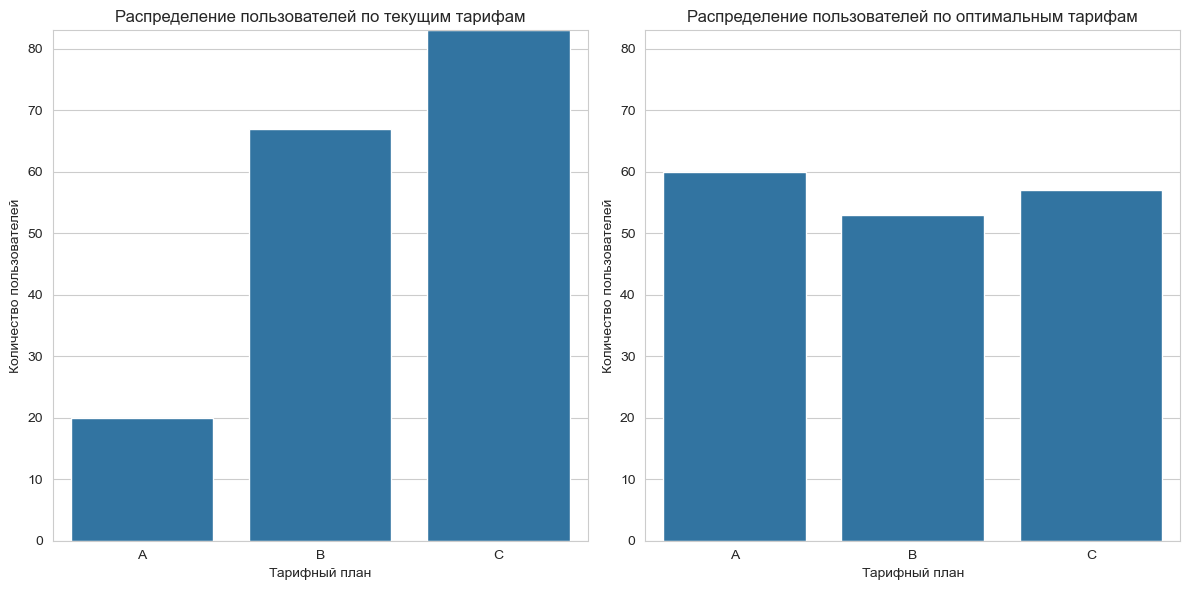

In [272]:
# Список категорий и порядок
categories_order = ["A", "B", "C"]

# Применение категории с установленным порядком
result_grouped_optimal_tariff_list["optimal_tariff_plan_mode"] = \
    result_grouped_optimal_tariff_list["optimal_tariff_plan_mode"].astype(pd.CategoricalDtype(categories=categories_order, ordered=True))

result_grouped_optimal_tariff_list["tariff_plan"] = \
    result_grouped_optimal_tariff_list["tariff_plan"].astype(pd.CategoricalDtype(categories=categories_order, ordered=True))

# Определяем максимальную величину для общей оси Y
max_value = max(result_grouped_optimal_tariff_list["tariff_plan"].value_counts().max(),
                result_grouped_optimal_tariff_list["optimal_tariff_plan_mode"].value_counts().max())

# Рисование графиков
plt.figure(figsize=(12, 6))

# Левый график: Current Tariff Plan
plt.subplot(1, 2, 1)
sns.countplot(x="tariff_plan", data=result_grouped_optimal_tariff_list)
plt.title("Распределение пользователей по текущим тарифам")
plt.xlabel("Тарифный план")
plt.ylabel("Количество пользователей")
plt.ylim([0, max_value])  # Установили общую ось Y

# Правый график: Optimal Tariff Plan Mode
plt.subplot(1, 2, 2)
sns.countplot(x="optimal_tariff_plan_mode", data=result_grouped_optimal_tariff_list)
plt.title("Распределение пользователей по оптимальным тарифам")
plt.xlabel("Тарифный план")
plt.ylabel("Количество пользователей")
plt.ylim([0, max_value])  # Тоже устанавливаем общую ось Y

# Оптимизация расположения элементов
plt.tight_layout()

# Показываем графики
plt.show()

- Доля пользователей с тарифным планом A значительно прирастет после перевода части пользователей на оптимальный тариф
- Доля пользоватлей с тарифными планами B и C снизится после перехода на оптимальный тариф

Результаты:
- Мы создадили список клиентов со старым и новым(оптимальным) тарифом
- Мы построили графики с распределением пользователей по текущим тарифам и оптимальным:
    - Доля пользователей с тарифным планом A значительно прирастет после перевода части пользователей на оптимальный тариф
    - Доля пользоватлей с тарифными планами B и C снизится после перехода на оптимальный тариф

## 6 Проверка гипотез

### Проверим гипотезу "Стоимость услуг на тарифных планах A и B одинаковая".

- Нулевая гипотеза: различий в стоимости услуг на тарифных планах А и B нет 
- Альтернативня гипотеза: есть различие в стоимости услуг на тарифных планах А и B

In [151]:
print(monthly_costs_and_potential_savings_101['tc_tariff_a'].describe())
print(monthly_costs_and_potential_savings_101['tc_tariff_b'].describe())

count       248.000000
mean      23198.621371
std       27742.200830
min        5051.600000
25%        6176.000000
50%       11984.400000
75%       27666.400000
max      207222.400000
Name: tc_tariff_a, dtype: float64
count       248.000000
mean      25051.834476
std       34778.321937
min        2152.000000
25%        3651.375000
50%       10861.750000
75%       30879.875000
max      255040.500000
Name: tc_tariff_b, dtype: float64


In [152]:
# Посчитаем средние значения
tc_tariff_a_median = monthly_costs_and_potential_savings_101['tc_tariff_a'].median()
tc_tariff_b_median = monthly_costs_and_potential_savings_101['tc_tariff_b'].median()

# Выведем разницу на экран
print(f"Медиана средних расходов по тарифному плану А: {tc_tariff_a_median}")
print(f"Медиана средних расходов по тарифному плану B: {tc_tariff_b_median}")

Медиана средних расходов по тарифному плану А: 11984.400000000001
Медиана средних расходов по тарифному плану B: 10861.75


Медианы(как и средние) практически совпадают. При этом, в обоих случаях медиана в разы отличается от среднего(распределение отличается от нормального). Также дисперсии отличаются друг от друга на 25%, используем тест Манна-Уитни.

In [154]:
result_one = stats.mannwhitneyu(monthly_costs_and_potential_savings_101['tc_tariff_a'], monthly_costs_and_potential_savings_101['tc_tariff_b'])

#results = st.mannwhitneyu(tarif_a, tarif_b) 

alpha = 0.05

print('p-значение:', result_one.pvalue)

if (result_one.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

p-значение: 0.023359040312896272
Отвергаем нулевую гипотезу


Отвергаем нулевую гипотезу: различия в стоимости услуг между тарифами А и B есть.

### Проверим гипотезу "Время ожидания ответа на тарифных планах B и C одинаковое"

- Нулевая гипотеза: различий во времени ожидания ответа в тарифных планах B и С нет 
- Альтернативня гипотеза: есть различие во времения ожидания ответа в тарифных планах B и С

In [158]:
filtered_telecom_five = filtered_telecom_five.copy()
filtered_telecom_five['waiting_time'] = filtered_telecom_five['total_call_duration'] - filtered_telecom_five['call_duration']
filtered_telecom_five.head(3)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start,cur_monthly_fee,month,num_of_operators,waiting_time
0,166377,2019-08-05,out,True,880020,False,1,10,18,B,2019-08-01,2000,8,4,8
1,166377,2019-08-05,out,False,880020,False,2,3,29,B,2019-08-01,2000,8,4,26
2,166377,2019-08-06,out,False,880020,False,5,800,819,B,2019-08-01,2000,8,4,19


In [159]:
tariff_B_tot_waiting_time = filtered_telecom_five.query('tariff_plan == "B"')['waiting_time']
tariff_C_tot_waiting_time = filtered_telecom_five.query('tariff_plan == "C"')['waiting_time']

In [160]:
print(tariff_B_tot_waiting_time.describe())
print(tariff_C_tot_waiting_time.describe())

count    8077.000000
mean      147.932401
std       275.945873
min         0.000000
25%        16.000000
50%        45.000000
75%       153.000000
max      4171.000000
Name: waiting_time, dtype: float64
count     9334.000000
mean       145.349582
std        348.392918
min          0.000000
25%         19.000000
50%         50.000000
75%        148.000000
max      11122.000000
Name: waiting_time, dtype: float64


In [161]:
# Посчитаем средние значения
tariff_B_tot_waiting_time_median = tariff_B_tot_waiting_time.median()
tariff_C_tot_waiting_time_median = tariff_C_tot_waiting_time.median()


# Выведем разницу на экран
print(f"Медиана средних расходов по тарифному плану B: {tariff_B_tot_waiting_time_median}")
print(f"Медиана средних расходов по тарифному плану C: {tariff_C_tot_waiting_time_median}")

Медиана средних расходов по тарифному плану B: 45.0
Медиана средних расходов по тарифному плану C: 50.0


Медианы в обоих случаях в разы отличаются от средних значений, при этом, не сильно разнятся между собой. Также дисперсии отличаются друг от друга на 26%, используем тест Манна-Уитни.

In [163]:
result_two = stats.mannwhitneyu(tariff_B_tot_waiting_time, tariff_C_tot_waiting_time)

alpha = 0.05

print('p-значение:', result_two.pvalue)

if (result_two.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

p-значение: 0.01237935596188597
Отвергаем нулевую гипотезу


Отвергаем нулевую гипотезу: различие во времени ожидания ответа в тарифных планах B и С есть.

Проверка гипотез:
   - Нулевая гипотеза: различий в стоимости услуг на тарифных планах А и B нет. Мы отвергли нулевую гипотезу: различия в стоимости услуг между тарифами А и B есть при уровне значимости 5%. 
   - Нулевая гипотеза: различий во времени ожидания ответа в тарифных планах B и С нет. Мы отвергли нулевую гипотезу: различия во времени ожидания ответа в тарифных планах B и С есть при уровне значимости alpha 5%. 

## 7 Общий вывод

1. Мы загрузили данные из фаилов. В первом датасете есть пропуски. Названия столбцов редактировать не нужно. В некоторых столбцах нужно преобразовать данные в нужный тип.

2. Мы провели предобработку данных:
   - Проверили наличие дубликатов. Идентифицировали 4,900(9%) явных дубликата. Удалили их.
   - Проверили наличие пропусков:
     - Удалили строки с пропущенными данными в столбце internal(их очень мало)
     - В столбце operator_id пропусков идентифицировано в размере 7,456 штук(15.2%). Их удалять не стали, так как это может исказить результаты исследования (как следствие значительная часть клиентов уйдет от нас, которая нам приносит прибыль). Пропуски могут быть связаны с какими-то техническими проблемами(система не указывает оператора из-за технического сбоя). Заменили эти пропуски самыми часто встречаемыми операторами у данных клиентов(user_id)
   - Объединили два датасета по столбцу user_id. В объединенный датасет вошли все строки из основного датасета dataset. У всех клиентов указан тарифный план(нет пропусков)
   - Изменили типы данных некоторых столбцов:
     - Преобразовали столбец 'date' в формат даты
     - Преобразовали столбец 'date_start' в формат даты
     - Привели идентификаторов операторов к целочисленному типу int
     - Привели тип данныйх к булевому в столбце internal
   - Проверили есть ли в датасете даты обслуживания клиентов, которые старше дат заключения с ними договоров. Количество записей обслуживания клиентов с датами старше дат их регистрации: 0.
   - Добавили столбец с месячной абонентской платой cur_monthly_fee

3. Мы провели исследовательский анализ данных:
   - Вычислили границы анализируемого периода: начало периода: 2019-08-02,конец периода: 2019-11-28. Учитывая что мы выяснили, что самый большой трафик приходится на ноябрь, мы не стали ноябрьские данные редактировать(урезать), так как мы могли потерять ценную информацию для принятия решения по переводу клиентов на новый тариф.
   - Построили график распределения количества звонков по датам. Звонки растут от месяца к месяцу. На выходных звонков традиционно меньше.
   - Проанализировали соотношение входящих и исходящих звонков. 59% звонков - входящие. Они бесплатные. Но клиенты, которые используют только входящие звонки, платят ежемесячную абонентскую плату плюс за каждого оператора. Их удалаять нельзя.
   - Посчитали количество пропущенных звонков. Довольно много пропущенных вызовов(43.8%). Они нам не нужны для дальнейших расчетов. Мы их удалали.
   - Проанализировали общее количество звонков среди клиентов. В 75% случаях на одного клиента приходится до 869 звонка. Имеется большое количество выбросов. Самое большое количество - 83,276 звонков. Для фильтрации определили границы: нижняя граница - 1-й процентиль(0.01), верхняя граница - 99-й процентиль(0.99). Такой подход оставил ещё меньше экстремумов, оставляя лишь самые центрированные данные. Мы отфильтровали датасет по количеству звонков: убрали всех клиентов(5.36% от всех записей), у которых суммарное количество звонков больше 15,852 штук.
   - Мы проанализировали общую длительность звонков. 75% пользователей имеют общую длительность звонков до 89,833 минут. Имелось большое количество выбросов. Максимальная длительность звонков у одного пользователя - 646,593 минут. Для фильтрации определили границы: нижняя граница - 1-й процентиль(0.005), верхняя граница - 99-й процентиль(0.995). Количество строк отфильтрованного датафрейма на 6.16% меньше датафрейма до фильтрации.
   - Проанализировали количество исходящих звонков по месяцам.Количество исходящих звонков(внутри и вне сети) постоянно растет. Резкий рост замедляется на 4-м месяце. Доля исходящих звонков внутри сети незначительная.
   - Проанализировали общую продолжительность исходящих звонков по месяцам. Аналогичная ситуация на этом графике: каждый месяц имеется значительный прирост. Рост замедляется(стабилизируется) на 4-м месяце. Доля звонков внутри сети минимальная.
   - Построили графики распределения абонентов по тарифным планам:
     - Доля клиентов с тарифными планоми А и B практически не меняется от месяца к месяцу
     - Доля клиентов с тарифным планом C постепенно растет первые три месяца
   - Разделили клиентов на активных и неактивных. К активным клиентам причислили тех пользователей услуг, которые присутствуют в датасете в ноябре. Мы отфильтровали 1,090(4.5%) записей с неактивными пользователями. Остальных всех пользователей будем считать активными.
   - Построили графики распределений пользователей по тарифным планам: по всем пользователям и отдельно по активным. Доли активных пользователей остались примерно на том же уровне что и в основном датасете. Наша выборка - репрезентативная. Общее количество активных пользователей меньше на 44(15.7%) единицы.

4. Мы сделали следующие расходы:
   - Мы посчитали количество операторов для каждого клиента помесячно
   - Посчитали расходы на исходящие звонки внутри сети
   - Посчитали суммарные расходы клиентов на исходящие звонки вне сети
   - Посчитали суммарные расходы по каждому тарифу в разрезе пользователей помесячно
   - Посчитали общую возможную экономию для клиентов за 4 месяца:
     - Общая выручка за 4 месяца: 9,157,124.95 рублей
     - Общая сумма потенциальной экономии для клиентов за 4 месяца: 2,104,373.9 рублей
   - Посчитали среднемесячную потенциальную экономию клиентов:
     - Общая среднемесячная выручка на данный момент: 3,387,895.0 рублей
     - Общая сумма потенциальных экономии для клиентов в месяц: 932,538.7 рублей
  
5. Мы создали список клиентов со старым и новым(оптимальным) тарифом:
   - Мы создали список клиентов со старым и новым(оптимальным) тарифом
   - Мы построили графики с распределением пользователей по текущим тарифам и оптимальным:
     - Доля пользователей с тарифным планом A значительно прирастет после перевода части пользователей на оптимальный тариф
     - Доля пользоватлей с тарифными планами B и C снизится после перехода на оптимальный тариф

6. Мы проверили следующие гипотезы:
   - Нулевая гипотеза: различий в стоимости услуг на тарифных планах А и B нет. Мы отвергли нулевую гипотезу: различия в стоимости услуг между тарифами А и B есть при уровне значимости 5%. 
   - Нулевая гипотеза: различий во времени ожидания ответа в тарифных планах B и С нет. Мы отвергли нулевую гипотезу: различия во времени ожидания ответа в тарифных планах B и С есть при уровне значимости alpha 5%. 


Ссылка на презентацию: https://disk.yandex.ru/i/F9DziSTs_xpjyQ